Let's try to sharpen the images or look at the surrounding area of each pixel to highlight areas that may have an issue. Then let's look at
trying to quantify the noise in each image.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()

powderthickness = 80
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
ims = np.array([np.array(plt.imread(path)) for path in paths_sorted])

# Don't touch original
integrals = np.copy(ims)

In [3]:
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)


In [4]:
segmentsize = 24

segmentdf = pd.read_csv('Segments.csv', names=[
                        "Object", "Segment", "P", "S", "H", "Porosity", "Area"])
segmentdf.insert(1, "VED", segmentdf.P * 1000 /
                 (segmentdf.S * segmentdf.H * powderthickness))
segmentCoordinates = objectCoordinates = [[x, x+objectwidth, yi, yi+segmentsize] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth) for yi in range (y+2, y+segmentsize*5, segmentsize)]
tdf = pd.DataFrame(objectCoordinates, columns=[
                       'xstart', 'xend', 'ystart', 'yend'])
segmentdf = tdf.join(segmentdf)

# imageNo = 93
# for index, object in segmentdf.iterrows():
#     plt.title("Object " + str(object.Object) + " segment " + str(object.Segment))
#     plt.imshow(integrals[imageNo, object.ystart:object.yend,
#                object.xstart:object.xend])
#     plt.figure()
# plt.title("OT/area vs porosity")
# x = [np.sum(integrals[imageNo, object.ystart:object.yend, object.xstart:object.xend]) / object.Area
#      for index, object in segmentdf.iterrows()]
# y = segmentdf.Porosity
# scatter = plt.scatter(x, y, c=segmentdf.Segment,  s=10)
# legend1 = plt.legend(*scatter.legend_elements(),
#                     loc="upper right", title="Segment")
# # for index, row in segmentdf.iterrows():
# #     plt.annotate(text=row.Object, xy=(x[index], y[index]))
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel('Porosity, %')
# plt.xlabel('OT/mm2')
# plt.add_artist(legend1)
# plt.legend()
# plt.figure()

In [5]:
import cv2
# How do we implement the sharpening?
# A simple approach would be to do 2d convolution across the integrals
# A more ambitious approach would be to look at the surrounding pixels and use if/else logic to set the value to 0 or 1 depending on whether it fits some threshold

# image = integrals[93] // 2
# image = np.copy(integrals[93])

# kernel = np.array([[0, -1, 0],
#                    [-1, 5, -1],
#                    [0, -1, 0]])
# image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
# plt.imshow(image_sharp)
# plt.figure()
# plt.imshow(integrals[93])

# imageNo = 93
# max_val = np.max(image_sharp)
# for index, object in objectinfo.sort_values(by=['VED']).iterrows():
#     img = image[object.ystart:object.yend,
#                     object.xstart:object.xend]
#     max_img = np.max(img)
#     ratio = max_val / max_img
#     image[object.ystart:object.yend,
#           object.xstart:object.xend] = img * ratio
#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,5))
#     ax1.set_title("Original")
#     ax2.set_title("Relative")
#     ax3.set_title("Sharpening")
#     ax4.set_title("Histogram")
#     fig.suptitle("Object " + object.Object + " (" +
#                     str(object.Porosity) + "% porosity) layer " + str(imageNo))
#     ax1.imshow(integrals[imageNo, object.ystart:object.yend,
#                 object.xstart:object.xend], vmin=0, vmax=65535)
#     ax2.imshow(integrals[imageNo, object.ystart:object.yend,
#                 object.xstart:object.xend])
#     ax3.imshow(image_sharp[object.ystart:object.yend,
#                         object.xstart:object.xend])
#     ax4.hist(image_sharp[object.ystart:object.yend,object.xstart:object.xend].flatten(), bins=100, color='r', range=(0,65535))
#     ax4.set_yscale('log')
# plt.figure()
# plt.imshow(image)
# plt.figure()
# plt.imshow(integrals[93])

Let's use the spatial KD approach from the book.

(225, 2000, 2000)


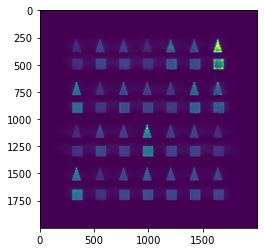

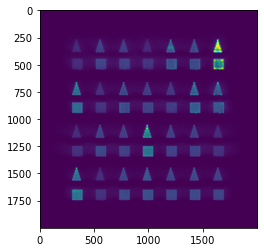

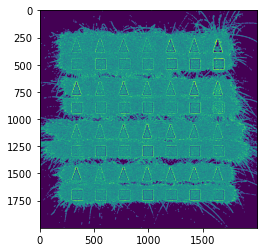

In [12]:
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])/9
veryBlurredLayers = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=kernel) for image in integrals])
print(np.shape(veryBlurredLayers))
plt.imshow(integrals[93])
plt.figure()
plt.imshow(veryBlurredLayers[93])
plt.figure()
plt.imshow(integrals[93] - veryBlurredLayers[93])

In [20]:
pointsToPlot = []
windowSize = 3
endLayer = 182
# We wanna check for each object...
np.sum(0)
neighbourhoodValues = np.array([np.sum(veryBlurredLayers[layerIndex-windowSize:layerIndex], axis=0)/windowSize
                               for layerIndex in range(windowSize, endLayer)])
# Counts 0..windowsize-1, 1..windowSize ... endLayer-windowSize-1..endLayer-2
# integral counts windowSize, windowSize+1, ... endLayer-1
# Two options: we either check only previous layers, or we include current layer in the calculation.
# Pro of including current layer: sort of makes more sense. Look in 3d etc etc.
# What's our resolution again?

/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_19289/1011282596.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


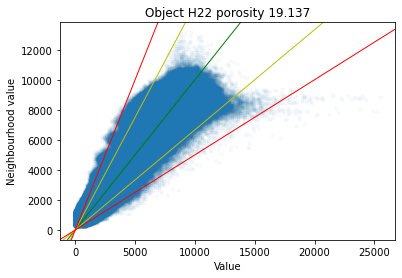

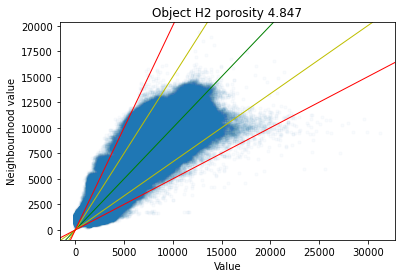

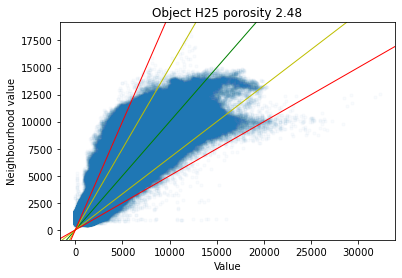

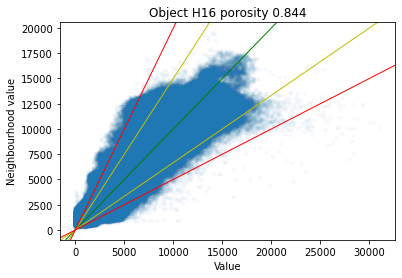

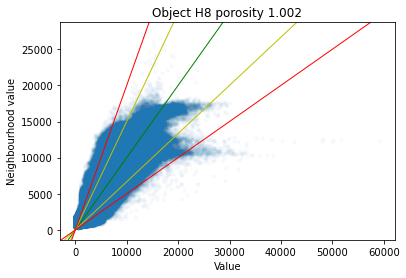

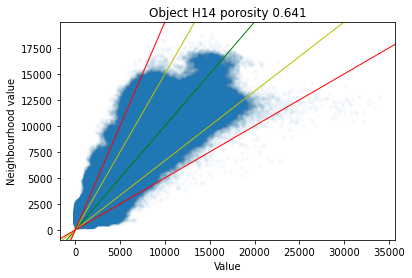

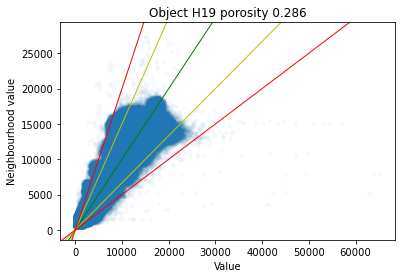

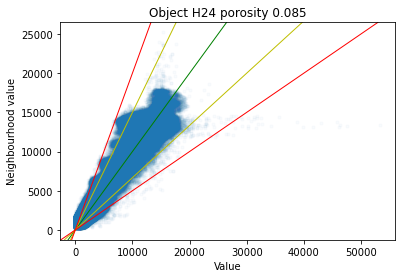

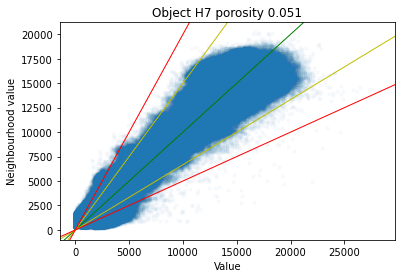

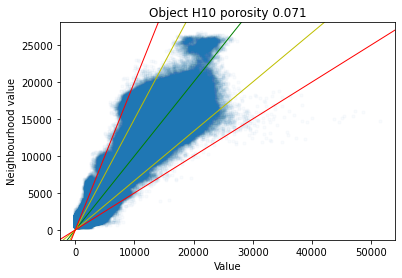

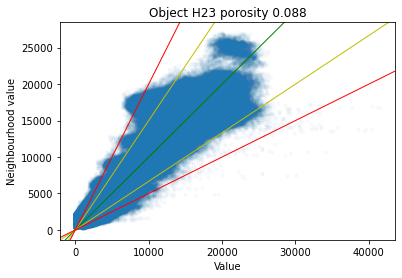

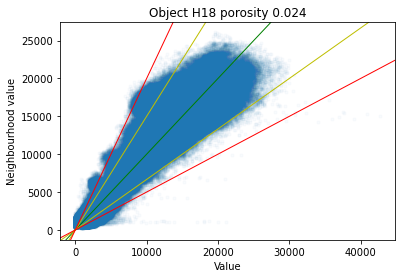

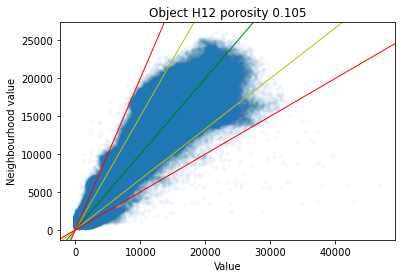

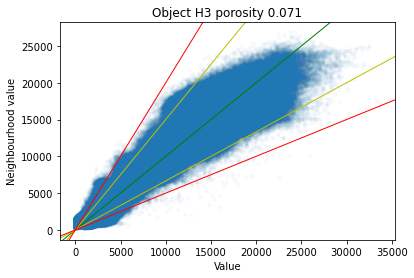

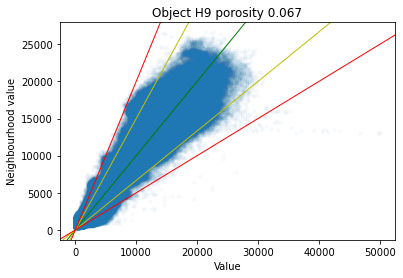

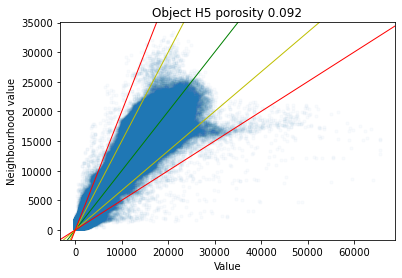

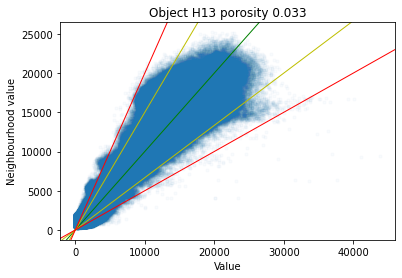

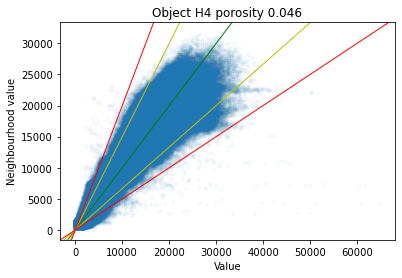

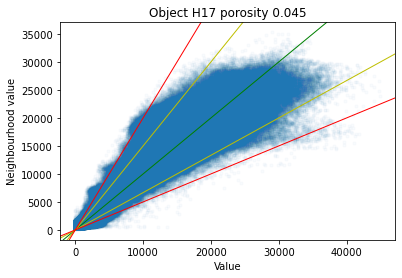

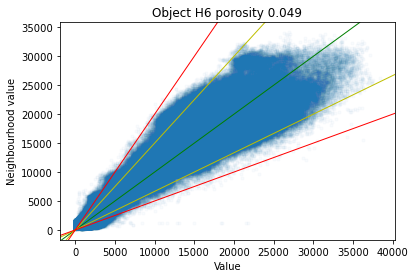

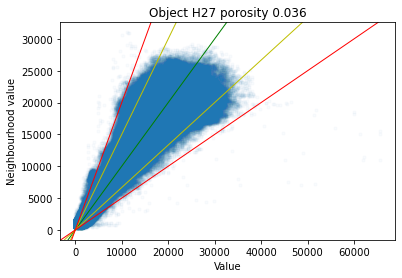

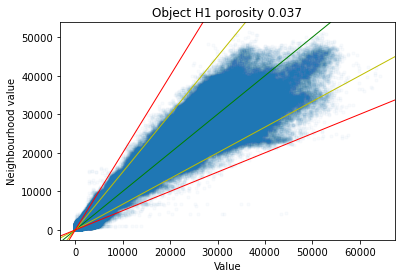

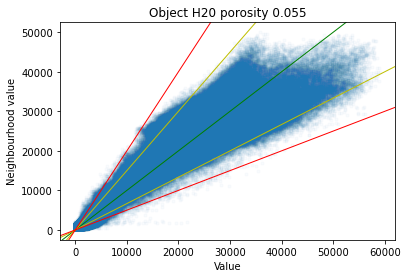

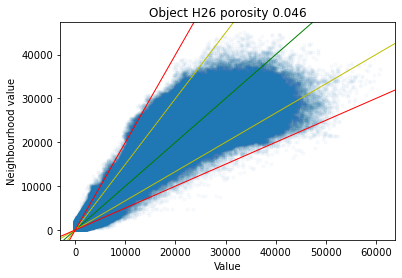

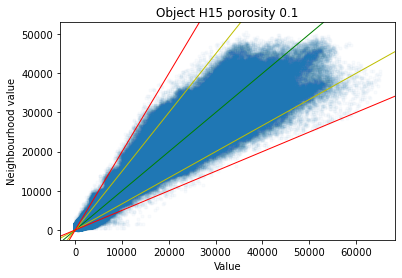

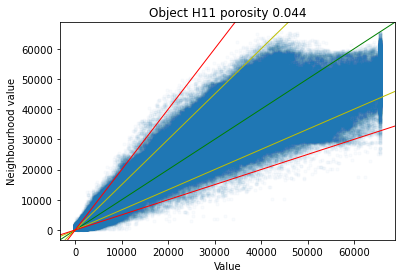

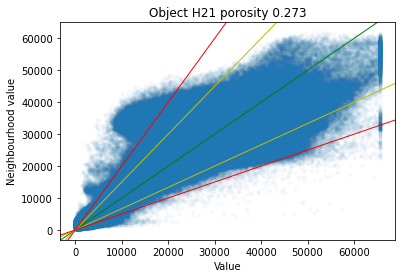

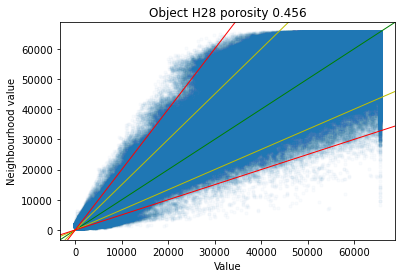

<Figure size 432x288 with 0 Axes>

In [91]:
objectinfo['lower_than_0.67'] = 0
objectinfo['lower_than_0.5'] = 0
objectinfo['higher_than_1.5'] = 0
objectinfo['higher_than_2'] = 0
objectinfo['total_1.5'] = 0
objectinfo['total_2'] = 0

layer = 93
for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    #     plt.title("Object " + str(object.Object) + " segment " + str(object.Segment))
    # xs = integrals[windowSize-1:endLayer-1, object.ystart:object.yend,object.xstart:object.xend]
    xs = integrals[windowSize:endLayer,object.ystart:object.yend, object.xstart:object.xend]
    ys = neighbourhoodValues[:, object.ystart:object.yend,object.xstart:object.xend]
    correlation = np.corrcoef(xs.flatten(), ys.flatten())
    ratio = xs/ys
    objectinfo.at[index, 'lower_than_0.67'] = np.count_nonzero((ratio < 1/1.5) & (xs > 4000))
    objectinfo.at[index, 'higher_than_1.5'] = np.count_nonzero((ratio > 1.5) & (xs > 4000))
    objectinfo.at[index, 'lower_than_0.5']  = np.count_nonzero((ratio < 1/2) & (xs > 4000))
    objectinfo.at[index, 'higher_than_2']   = np.count_nonzero((ratio > 2) & (xs > 4000))
    objectinfo.at[index, 'total_1.5']       = np.count_nonzero(((ratio < 1/1.5) | (ratio > 1.5)) & xs > 4000)
    objectinfo.at[index, 'total_2']         = np.count_nonzero(((ratio < 1/2) | (ratio > 2)) & xs > 4000)

    plt.title("Object " + str(object.Object) +
              " porosity " + str(object.Porosity))
    plt.scatter(xs, ys, s=10, alpha=0.025)
    plt.axline((0, 0), (1, 1), linewidth=1, color='g')
    plt.axline((0, 0), (1, 1.5), linewidth=1, color='y')
    plt.axline((0, 0), (1.5, 1), linewidth=1, color='y')
    plt.axline((0, 0), (2, 1), linewidth=1, color='r')
    plt.axline((0, 0), (1, 2), linewidth=1, color='r')
    plt.xlabel("Value")
    plt.ylabel("Neighbourhood value")
    plt.figure()


<Figure size 432x288 with 0 Axes>

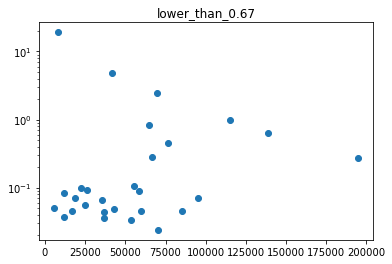

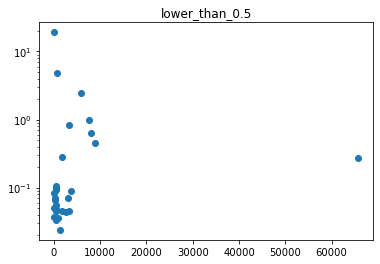

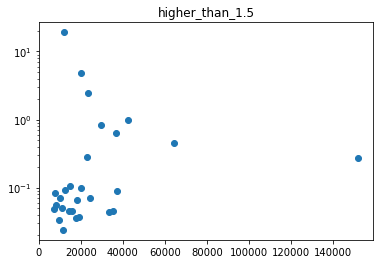

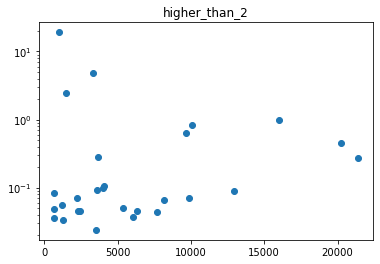

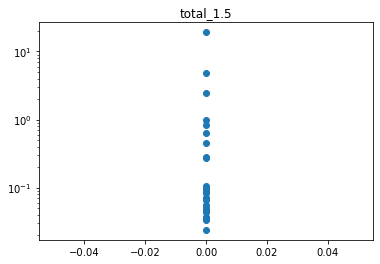

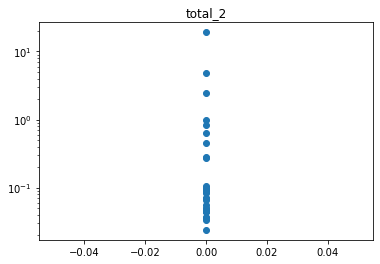

<Figure size 432x288 with 0 Axes>

In [92]:
plt.scatter(objectinfo['lower_than_0.67'], objectinfo['Porosity'])
plt.title('lower_than_0.67')
plt.yscale('log')
plt.figure()
plt.scatter(objectinfo['lower_than_0.5'], objectinfo['Porosity'])
plt.title('lower_than_0.5')
plt.yscale('log')
plt.figure()
plt.scatter(objectinfo['higher_than_1.5'], objectinfo['Porosity'])
plt.title('higher_than_1.5')
plt.yscale('log')
plt.figure()
plt.scatter(objectinfo['higher_than_2'], objectinfo['Porosity'])
plt.title('higher_than_2')
plt.yscale('log')
plt.figure()
plt.scatter(objectinfo['total_1.5'], objectinfo['Porosity'])
plt.title('total_1.5')
plt.yscale('log')
plt.figure()
plt.scatter(objectinfo['total_2'], objectinfo['Porosity'])
plt.title('total_2')
plt.yscale('log')
plt.figure()


/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_19289/1160774845.py:14: RuntimeWarning: divide by zero encountered in true_divide
  ratio = xs/ys
/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_19289/1160774845.py:14: RuntimeWarning: invalid value encountered in true_divide
  ratio = xs/ys


<Figure size 432x288 with 0 Axes>

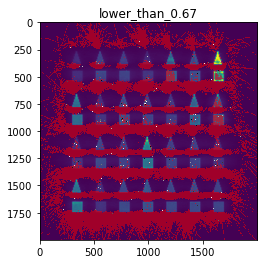

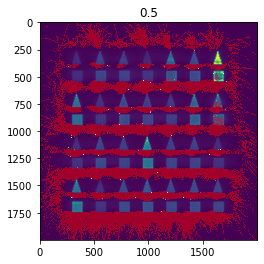

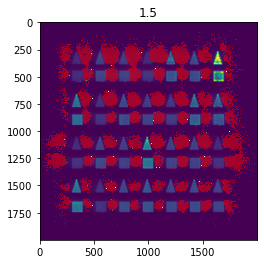

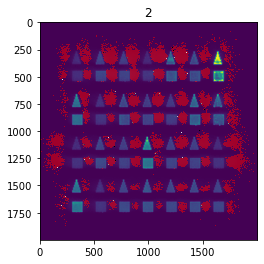

<Figure size 432x288 with 0 Axes>

In [85]:
# Let's color code the dots on an image that fits the bill so to say
from copy import copy
from matplotlib import cm, colors
image = integrals[93]

# make a copy so we don't mess up system copy
my_cmap = copy(cm.get_cmap('gray'))
my_cmap.set_under('r', alpha=.5)  # make locations over vmax translucent red
my_cmap.set_over('w', alpha=0)   # make location under vmin transparent white
my_cmap.set_bad('w', alpha=0)             # make location with invalid data green

xs = image
ys = neighbourhoodValues[93-windowSize-1]
ratio = xs/ys
# ratio[np.isnan(ratio)] = 0
# ratio[np.isinf(ratio)] = 0
plt.title('lower_than_0.67')
plt.imshow(image)
my_norm = colors.Normalize(vmin=.66, vmax=.67, clip=False)
plt.imshow(ratio, norm=my_norm, cmap=my_cmap, interpolation='nearest')
plt.figure()

plt.title('0.5')
plt.imshow(image)
my_norm = colors.Normalize(vmin=.5, vmax=.51, clip=False)
plt.imshow(ratio, norm=my_norm, cmap=my_cmap, interpolation='nearest')
plt.figure()

my_cmap2 = copy(cm.get_cmap('gray'))
my_cmap2.set_over('r', alpha=.5)  # make locations over vmax translucent red
my_cmap2.set_under('w', alpha=0)   # make location under vmin transparent white
# make location with invalid data green
my_cmap2.set_bad('w', alpha=0)

plt.title('1.5')
plt.imshow(image)
my_norm = colors.Normalize(vmin=1.5, vmax=1.51, clip=False)
plt.imshow(ratio, norm=my_norm, cmap=my_cmap2, interpolation='nearest')
plt.figure()

plt.title('2')
plt.imshow(image)
my_norm = colors.Normalize(vmin=2, vmax=2.01, clip=False)
plt.imshow(ratio, norm=my_norm, cmap=my_cmap2, interpolation='nearest')
plt.figure()


<Figure size 432x288 with 0 Axes>

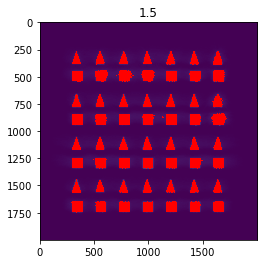

<Figure size 432x288 with 0 Axes>

In [90]:
my_cmap2 = copy(cm.get_cmap('gray'))
my_cmap2.set_over('r', alpha=1)  # make locations over vmax translucent red
my_cmap2.set_under('w', alpha=0)   # make location under vmin transparent white
# make location with invalid data green
my_cmap2.set_bad('w', alpha=0)

plt.title('1.5')
plt.imshow(image)
my_norm = colors.Normalize(vmin=4000, vmax=4001, clip=False)
plt.imshow(image, norm=my_norm, cmap=my_cmap2, interpolation='nearest')
plt.figure()

4000 filters noise nicely


<Figure size 432x288 with 0 Axes>

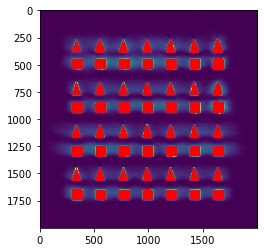

<Figure size 432x288 with 0 Axes>

In [102]:
my_cmap2 = copy(cm.get_cmap('gray'))
my_cmap2.set_over('r', alpha=1)  # make locations over vmax translucent red
my_cmap2.set_under('w', alpha=0)   # make location under vmin transparent white
# make location with invalid data green
my_cmap2.set_bad('w', alpha=0)

plt.imshow(image, vmax=10000)
my_norm = colors.Normalize(vmin=5000, vmax=5001, clip=False)
plt.imshow(neighbourhoodValues[93-windowSize-1],
           norm=my_norm, cmap=my_cmap2, interpolation='nearest')
plt.figure()


Let's try this with stddev instead

/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_19289/103589373.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


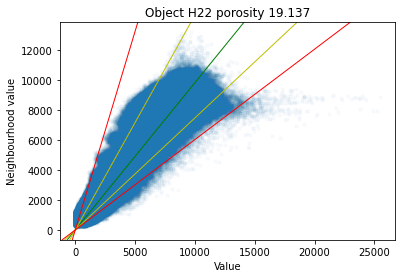

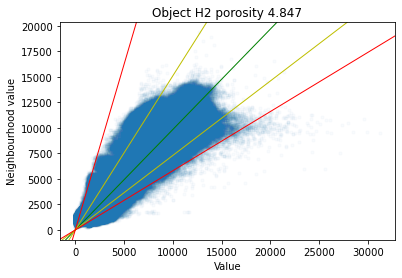

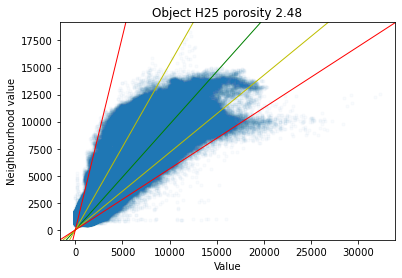

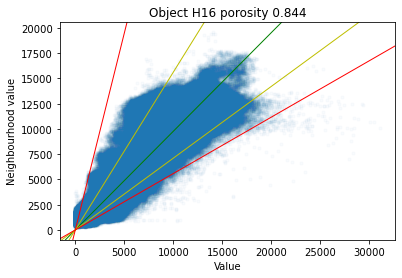

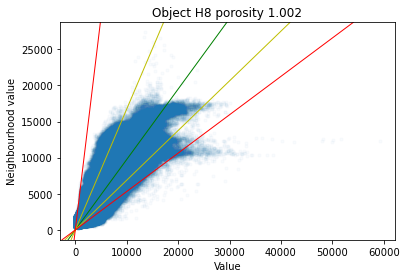

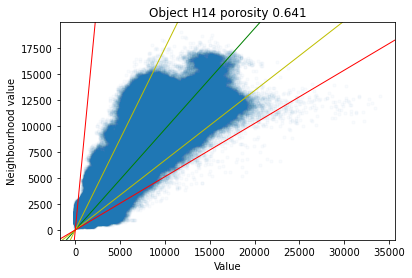

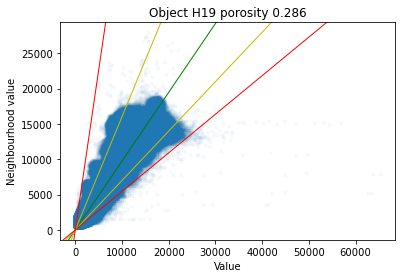

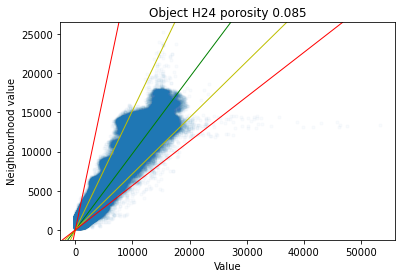

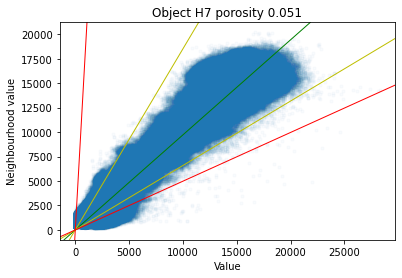

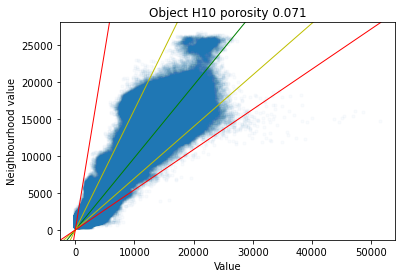

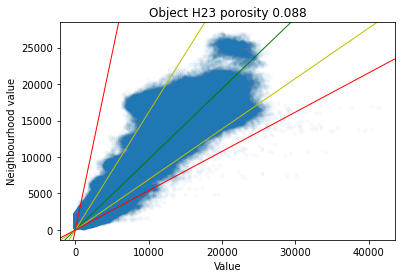

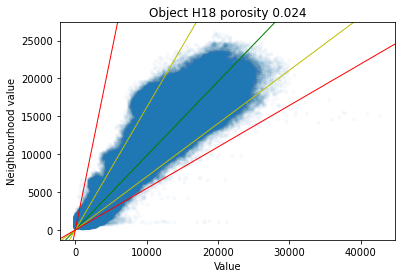

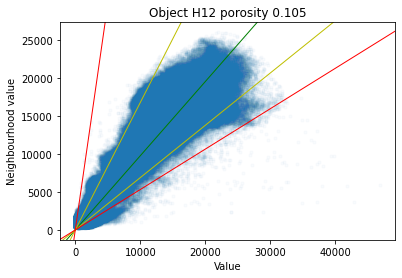

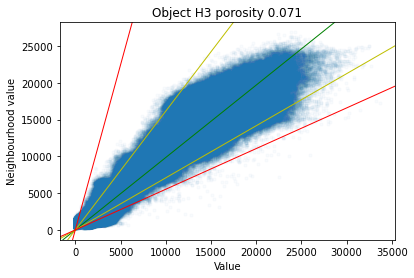

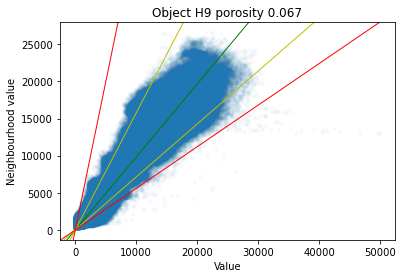

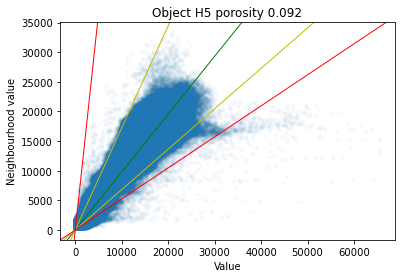

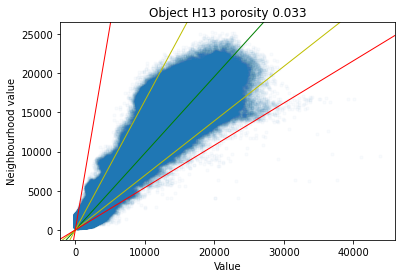

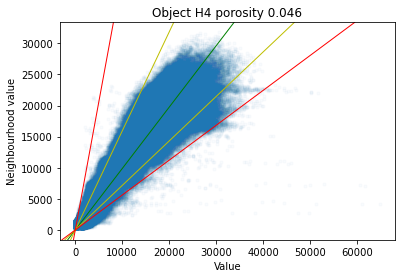

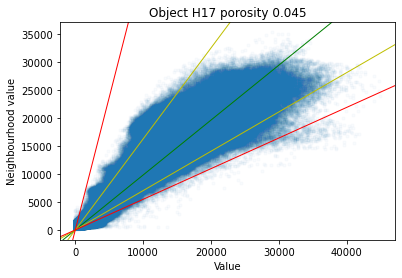

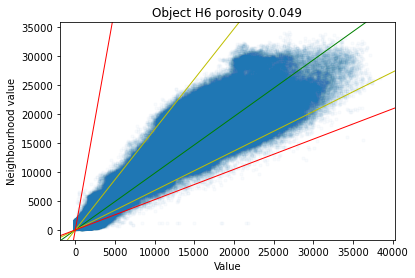

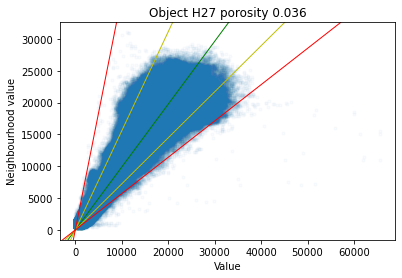

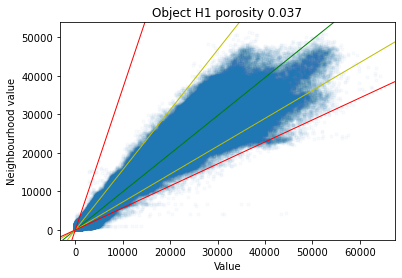

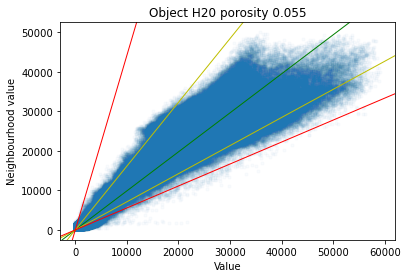

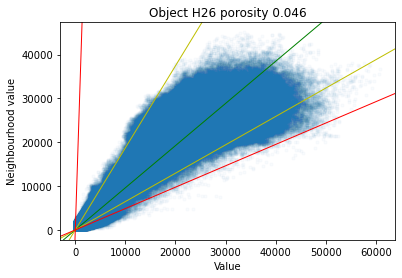

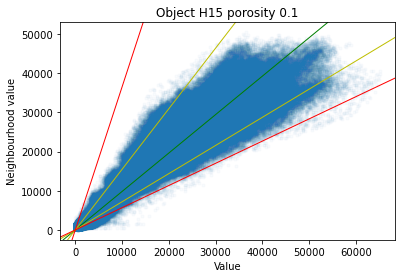

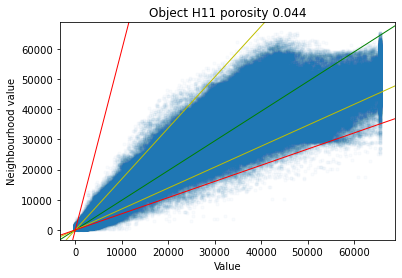

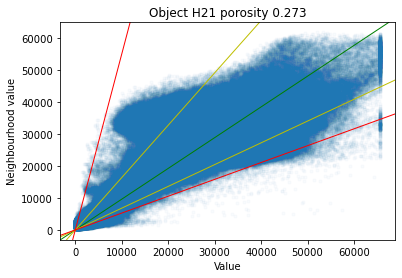

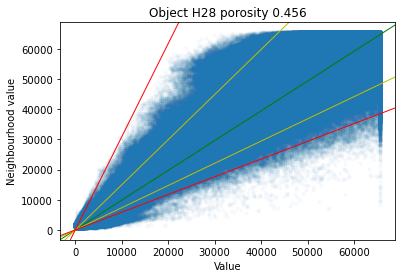

<Figure size 432x288 with 0 Axes>

In [43]:
for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    #     plt.title("Object " + str(object.Object) + " segment " + str(object.Segment))
    ys = neighbourhoodValues[:, object.ystart:object.yend,
                             object.xstart:object.xend]
    xs = integrals[windowSize:endLayer, object.ystart:object.yend,
                   object.xstart:object.xend]
    correlation = np.corrcoef(xs.flatten(), ys.flatten())
    ratio = xs/ys
    avg = np.average(ratio)
    stddev = np.std(ratio)

    plt.title("Object " + str(object.Object) +
              " porosity " + str(object.Porosity))
    plt.scatter(xs, ys, s=10, alpha=0.025)
    plt.axline((0, 0), (avg, 1), linewidth=1, color='g')
    plt.axline((0, 0), (avg-stddev, 1), linewidth=1, color='y')
    plt.axline((0, 0), (avg+stddev, 1), linewidth=1, color='y')
    plt.axline((0, 0), (avg-(stddev*2), 1), linewidth=1, color='r')
    plt.axline((0, 0), (avg+(stddev*2), 1), linewidth=1, color='r')
    plt.xlabel("Value")
    plt.ylabel("Neighbourhood value")
    # plt.xscale('log')
    # plt.yscale('log')
    plt.figure()

/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_19289/214257799.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


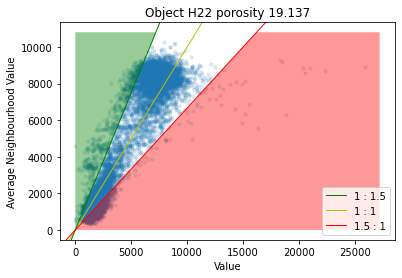

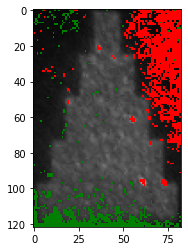

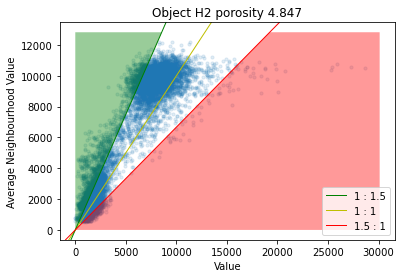

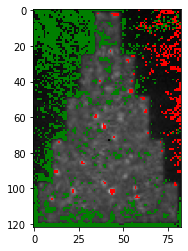

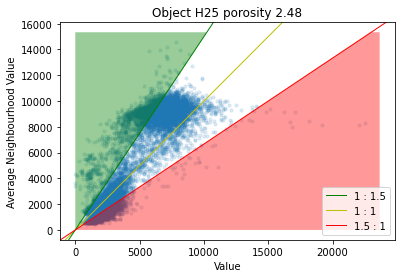

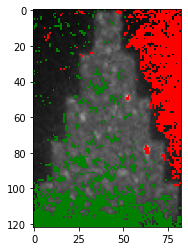

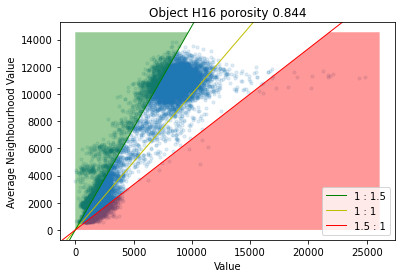

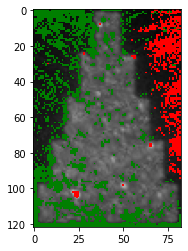

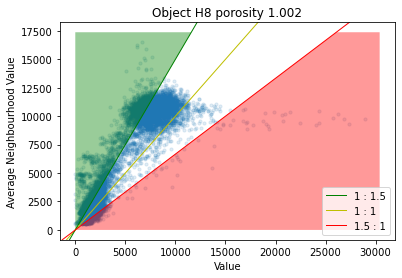

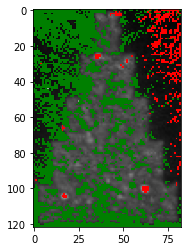

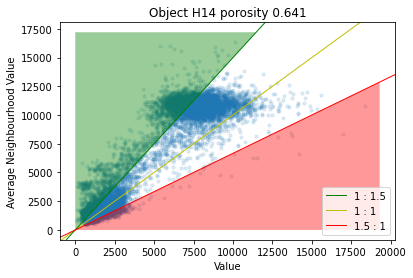

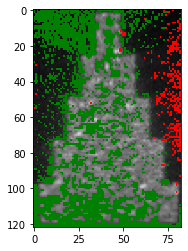

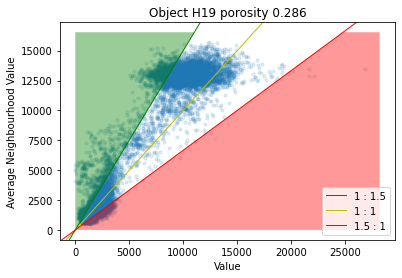

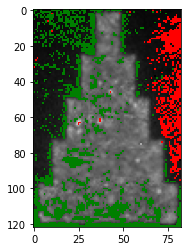

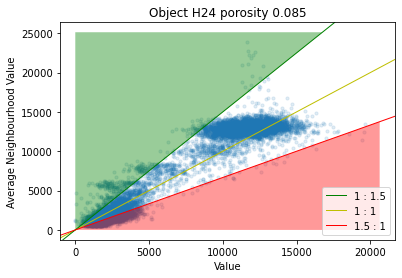

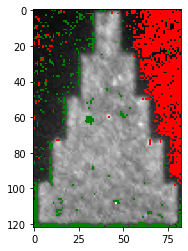

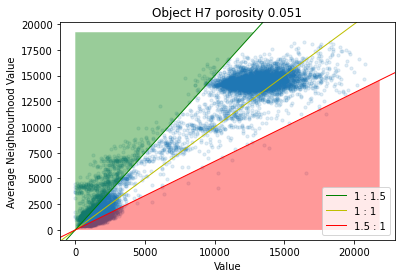

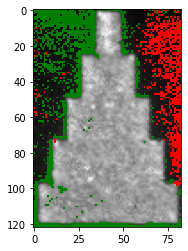

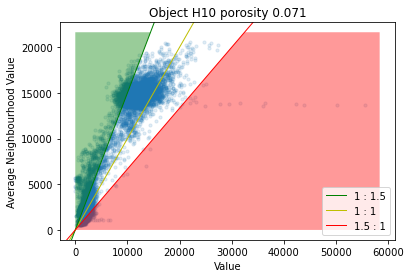

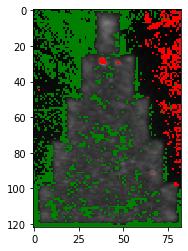

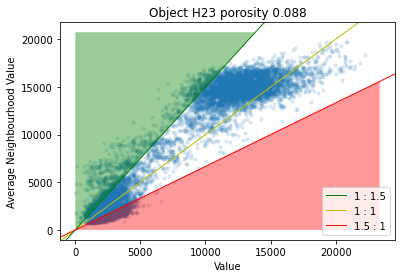

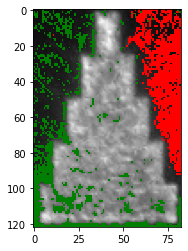

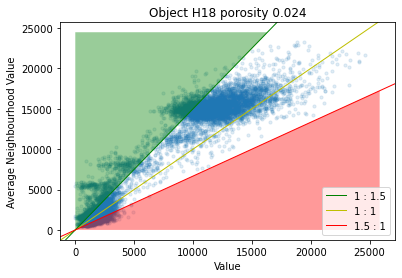

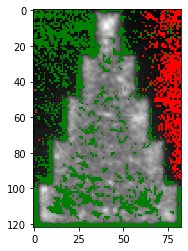

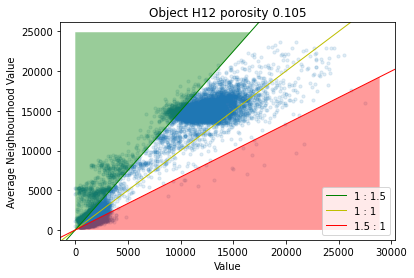

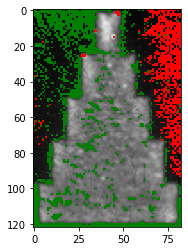

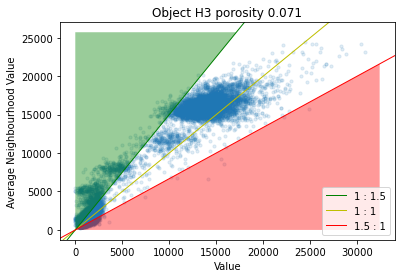

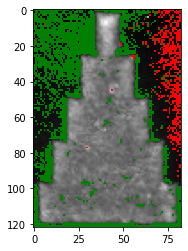

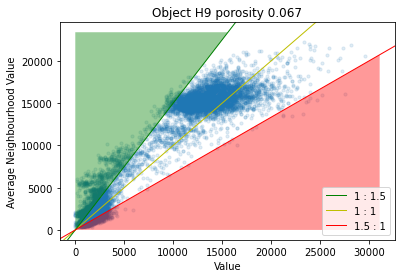

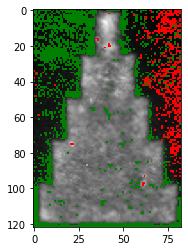

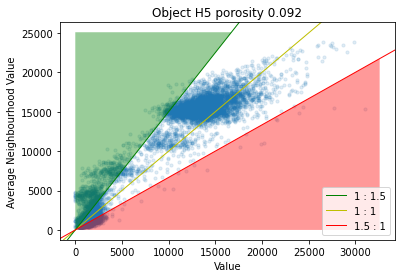

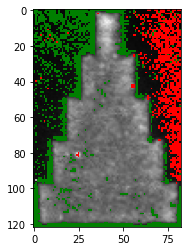

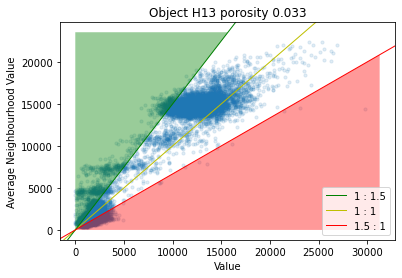

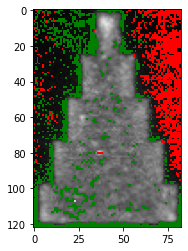

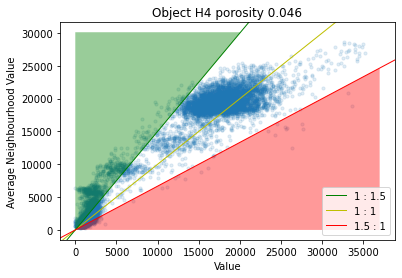

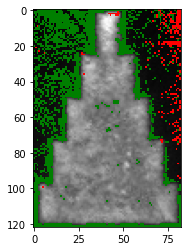

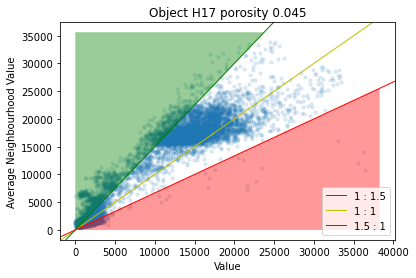

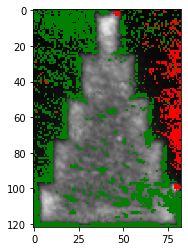

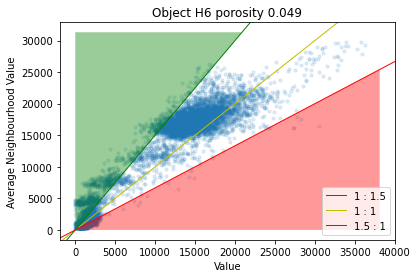

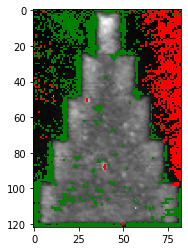

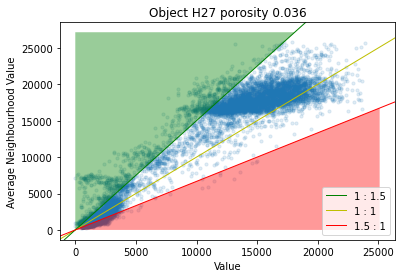

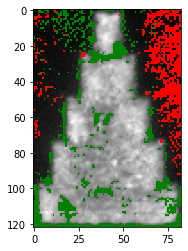

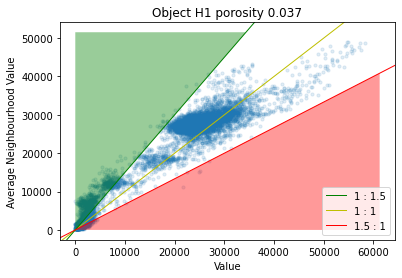

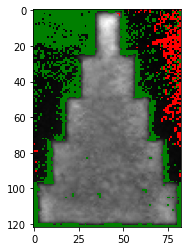

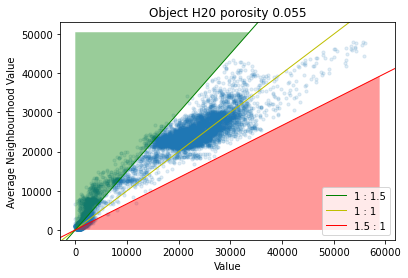

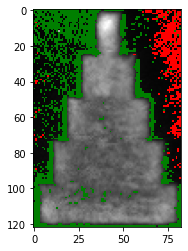

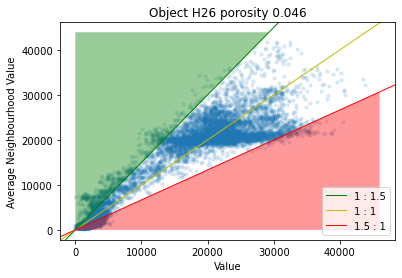

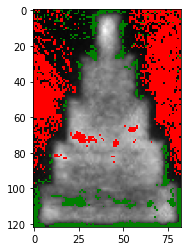

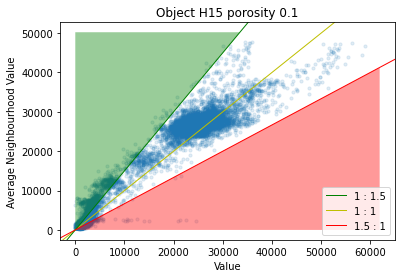

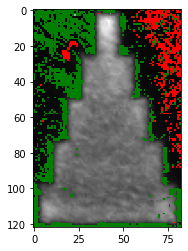

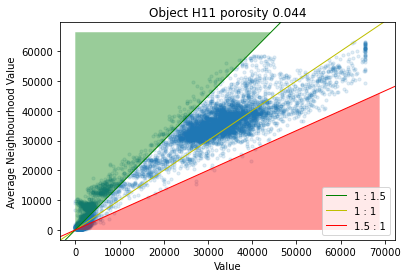

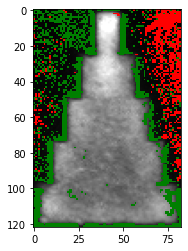

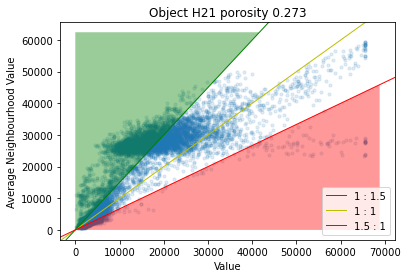

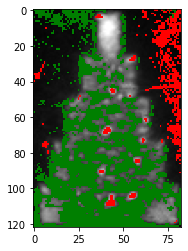

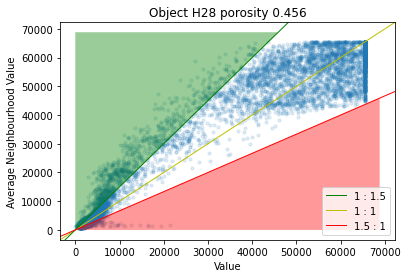

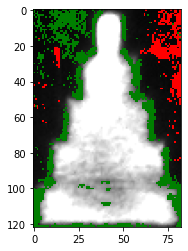

<Figure size 432x288 with 0 Axes>

In [140]:
objectinfo['lower_than_0.67'] = 0
objectinfo['lower_than_0.5'] = 0
objectinfo['higher_than_1.5'] = 0
objectinfo['higher_than_2'] = 0
objectinfo['total_1.5'] = 0
objectinfo['total_2'] = 0

kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
layer = 93
image_sharp = cv2.filter2D(src=integrals[layer], ddepth=-1, kernel=kernel)
ncopy = np.copy(neighbourhoodValues[layer-windowSize-2])
# ncopy[ncopy < 5000] = 0
# image_sharp[ncopy < 5000] = 0

for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    #     plt.title("Object " + str(object.Object) + " segment " + str(object.Segment))
    # xs = integrals[windowSize-1:endLayer-1, object.ystart:object.yend,object.xstart:object.xend]
    xs = image_sharp[object.ystart:object.yend, object.xstart:object.xend]
    ys = ncopy[object.ystart:object.yend,object.xstart:object.xend]
    ratio = xs/ys
    plt.title("Object " + str(object.Object) +
              " porosity " + str(object.Porosity))
    plt.scatter(xs, ys, s=10, alpha=0.125)
    l1 = plt.axline((0, 0), (1, 1), linewidth=1, color='y')
    l2 = plt.axline((0, 0), (1, 1.5), linewidth=1, color='g')
    l3 = plt.axline((0, 0), (1.5, 1), linewidth=1, color='r')
    plt.xlabel("Value")
    plt.ylabel("Average Neighbourhood Value")
    plt.legend([l2,l1,l3],['1 : 1.5','1 : 1','1.5 : 1'],loc="lower right")
    xmin, xmax, ymin, ymax = plt.axis()
    x = np.arange(0,xmax)
    x1 = x/1.5
    x1[x1 > ymax] = ymax
    y = np.arange(0,ymax)
    y1 = y/1.5
    y1[y1 > xmax] = xmax
    plt.fill_between(x, x1, 0, facecolor='r', alpha=0.4)
    plt.fill_betweenx(y, y1, 0, facecolor='g', alpha=0.4)
    plt.figure()
    
    
    plt.imshow(image_sharp[object.ystart:object.yend,
               object.xstart:object.xend], cmap="gray")
    # Start with higher
    my_cmap2 = copy(cm.get_cmap('gray'))
    my_cmap2.set_over('r')  # make locations over vmax translucent red
    my_cmap2.set_under('w', alpha=0)   # make location under vmin transparent white
    # make location with invalid data green
    my_cmap2.set_bad('w', alpha=0)
    my_norm = colors.Normalize(vmin=1.5, vmax=1.5001, clip=False)
    plt.imshow(ratio, norm=my_norm, cmap=my_cmap2, interpolation='nearest')
    # then lower
    my_cmap = copy(cm.get_cmap('gray'))
    my_cmap.set_under('g')  # make locations over vmax translucent red
    # make location under vmin transparent white
    my_cmap.set_over('w', alpha=0)
    # make location with invalid data green
    my_cmap.set_bad('w')
    my_norm = colors.Normalize(vmin=0.6666, vmax=0.6667, clip=False)
    plt.imshow(ratio, norm=my_norm, cmap=my_cmap, interpolation='nearest')
    plt.figure()
